In [1]:
# Modules for calculations
import numpy as np
import scipy
import torch
import qutip as qt

# Modules for plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import plasma

In [2]:
# Set number of trainable segments in composite pulse
N_TRAINING_SEGMENTS = 100

# Set bandwidth parameters
BANDWIDTH = 1e8 #Hz
OVERSAMPLING_FACTOR = 50
DELTA_T = 1 / (2 * OVERSAMPLING_FACTOR * BANDWIDTH)
LPF_SIGMA = np.sqrt(np.log(2)) / (2*np.pi * BANDWIDTH * DELTA_T)

# Define discretized composite search space
EPSILON_RANGE = 0.3 
EPSILON_N = 11
F_RANGE = 0.3
F_N = 11

# Set Rabi drive strength
OMEGA = 100e6 #rad/s
OMEGA_MAX = 200e6 #rad/s

# Set target operation
# In this example, we want to implement a pi-X gate
THETA = torch.tensor(np.pi)
PHI = torch.tensor(0)

# Choose an initial guess for the trainable parameters I[i] and Q[i] (i in [1..N_TRAINING_SEGMENTS])
# We take reduced CORPSE in BB1 as our initial guess
INITIAL_GUESS = 'rCinBB' 
I_ig = torch.zeros(N_TRAINING_SEGMENTS, dtype=torch.float64)
Q_ig = torch.zeros(N_TRAINING_SEGMENTS, dtype=torch.float64)
PI = torch.tensor(np.pi)
if INITIAL_GUESS == 'rCinBB':
    k = torch.arcsin(torch.sin(torch.tensor(THETA / 2)) / 2)
    theta_ig_rCinBB = [
        PI,
        2 * PI,
        PI,
        2 * PI + THETA / 2 - k,
        2 * PI - 2 * k,
        THETA / 2 - k]
    phi_ig_rCinBB = [
        PHI + torch.arccos(torch.tensor(-THETA / 4 / PI)),
        PHI + 3 * torch.arccos(torch.tensor(-THETA / 4 / PI)),
        PHI + torch.arccos(torch.tensor(-THETA / 4 / PI)),
        PHI,
        PHI + PI,
        PHI]
    total_theta = sum(theta_ig_rCinBB)
    total_time = total_theta/OMEGA
    for i in range(6):
        start_idx = int(np.rint(sum(theta_ig_rCinBB[:i])/total_theta * N_TRAINING_SEGMENTS))
        end_idx = int(np.rint(sum(theta_ig_rCinBB[:i+1])/total_theta * N_TRAINING_SEGMENTS))
        I_ig[start_idx:end_idx] = torch.cos(phi_ig_rCinBB[i]) * OMEGA / OMEGA_MAX
        Q_ig[start_idx:end_idx] = torch.sin(phi_ig_rCinBB[i]) * OMEGA / OMEGA_MAX

# Set number of time steps
UPSAMPLING_FACTOR = int(np.rint(total_time / (N_TRAINING_SEGMENTS * DELTA_T)))
UPSAMPLING_FACTOR = max(1, UPSAMPLING_FACTOR)
TIME_STEPS = N_TRAINING_SEGMENTS * UPSAMPLING_FACTOR

/var/folders/q0/7f04j2qd3gl8slmzfbwlpdhr0000gn/T/ipykernel_67866/509962071.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.arcsin(torch.sin(torch.tensor(THETA / 2)) / 2)
/var/folders/q0/7f04j2qd3gl8slmzfbwlpdhr0000gn/T/ipykernel_67866/509962071.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PHI + torch.arccos(torch.tensor(-THETA / 4 / PI)),
/var/folders/q0/7f04j2qd3gl8slmzfbwlpdhr0000gn/T/ipykernel_67866/509962071.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PHI + 3 * torch.arccos(torch.tensor(-THETA / 4 / PI)

In [3]:
class SAFE_GRAPE(torch.nn.Module):  
  def __init__(self, I_ig, Q_ig):
    super(SAFE_GRAPE, self).__init__()

    self.sigma_x = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex128)
    self.sigma_y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex128)
    self.sigma_z = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex128)

    self.I = torch.nn.Parameter(I_ig.clone().detach(), requires_grad=True)
    self.Q = torch.nn.Parameter(Q_ig.clone().detach(), requires_grad=True)

    K = int(4 * LPF_SIGMA)              
    k = torch.arange(-K, K + 1, dtype=torch.float64)
    h = torch.exp(-0.5 * (k / LPF_SIGMA) ** 2)
    h = h / h.sum()                     # DC gain = 1
    h = h.view(1, 1, -1)                # [1,1,L] for conv1d
    self.register_buffer("lpf_kernel", h)

  # Apply Gaussian weights to prioritize the center of the composite search space
  def apply_gaussian_weights(self, matrix, sigma_epsilon, sigma_f, normalize=True):
    M, N = matrix.shape
    y_coords, x_coords = torch.meshgrid(
        torch.arange(M, dtype=matrix.dtype, device=matrix.device),
        torch.arange(N, dtype=matrix.dtype, device=matrix.device),
        indexing='ij')
    center_x = (N - 1) / 2.0
    center_y = (M - 1) / 2.0
    
    gauss_mask = torch.exp(-(((x_coords - center_x) ** 2) / (2.0 * sigma_epsilon ** 2) + ((y_coords - center_y) ** 2) / (2.0 * sigma_f ** 2)))

    if normalize: # Normalize mask so that its sum is N*M
        gauss_mask /= gauss_mask.sum()
        gauss_mask *= (M * N)
        
    return matrix * gauss_mask

  # Define low pass filter to implement bandwidth constraint
  def lpf(self, x):
    x_ = x.view(1, 1, -1)                          # [1,1,L]
    pad = (self.lpf_kernel.shape[-1] - 1) // 2
    x_pad = torch.nn.functional.pad(x_, (pad, pad), mode="reflect")
    y = torch.nn.functional.conv1d(x_pad, self.lpf_kernel)
    return y.view(-1)

  # 3 step process to derive I,Q for each timestep from trainable parameters:
  # 1. upsampling
  # 2. low pass filter
  # 3. amplitude clipping
  def get_IQ(self):
    Irep = self.I.repeat_interleave(UPSAMPLING_FACTOR)
    Qrep = self.Q.repeat_interleave(UPSAMPLING_FACTOR)
    If = self.lpf(Irep)
    Qf = self.lpf(Qrep)
    amp = torch.sqrt(If**2 + Qf**2) + 1e-12
    scale = torch.clamp(1 / amp, max=1.0)
    If = If * scale
    Qf = Qf * scale
    return If, Qf

  # Define a real gate U(theta, phi) with amplitude error epsilon and frequency error f
  def V(self, t, I, Q, f, eps):
    return torch.matrix_exp(-1j * OMEGA_MAX * t / 2 * ( (1 + eps) *
            ( I * self.sigma_x + Q * self.sigma_y ) + f * self.sigma_z))

  # Define an ideal gate U(theta, phi)
  def U(self, theta, phi):
    return torch.matrix_exp(-1j * theta / 2 * (torch.cos(phi) * self.sigma_x + torch.sin(phi) * self.sigma_y))

  # Define a function to compute the average gate fidelity between two gates
  def average_gate_fidelity(self, U, V):
    return torch.abs(torch.trace(torch.matmul(torch.conj(U).t(), V)) / 2) # Assuming U and V are 2x2 matrices

  # For each point (epsilon, f) in the composite search space, compute the average gate infidelity between the ideal target gate and the real composite pulse sequence
  # The global optimization function is then the sum of all those values, corrected with the corresponding Gaussian weights
  def forward(self):
    I,Q = self.get_IQ() 
    infidelity = torch.zeros((EPSILON_N, F_N))
    for i, epsilon in enumerate(torch.linspace(-EPSILON_RANGE, EPSILON_RANGE, EPSILON_N)):
      for j, f in enumerate(torch.linspace(-F_RANGE, F_RANGE, F_N)):
        sequence = self.V(torch.tensor(0), torch.tensor(0), torch.tensor(0), 0, 0)
        for n in range(TIME_STEPS):
          sequence = torch.matmul(self.V(DELTA_T, I[n], Q[n], f, epsilon), sequence)
        infidelity[i, j] = 1 - self.average_gate_fidelity(sequence, self.U(THETA, PHI))
    weighted_infidelity = self.apply_gaussian_weights(matrix = infidelity, sigma_epsilon = EPSILON_N/3, sigma_f = F_N/3)
    return torch.sum(weighted_infidelity)

In [4]:
grape = SAFE_GRAPE(I_ig, Q_ig)
optimizer = torch.optim.LBFGS(grape.parameters(), lr=1, max_iter=200)

# Closure function for L-BFGS
def closure():
    optimizer.zero_grad()
    loss = grape()
    loss.backward()
    return loss

# Training loop
num_epochs = 1
I_history = []
Q_history = []

for epoch in range(num_epochs):
    optimizer.step(closure)  # L-BFGS optimization step with closure

    # Save parameters at each epoch
    I_history.append(grape.I.detach().clone().numpy())
    Q_history.append(grape.Q.detach().clone().numpy())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {closure().item()}')

# Get I,Q from the trained model
with torch.no_grad():
    If, Qf = grape.get_IQ()
    If = If.cpu().numpy()
    Qf = Qf.cpu().numpy()

Epoch [1/1], Loss: 0.012818895280361176


In [13]:
class CompositePulsePlots:
  def __init__(self, theta_target, phi_target, initial_I, initial_Q, final_I, final_Q):
    self.theta_target = theta_target
    self.phi_target = phi_target

    K = int(4 * LPF_SIGMA)
    k = np.arange(-K, K + 1, dtype=float)
    h = np.exp(-0.5 * (k / LPF_SIGMA) ** 2)
    h /= h.sum()  
    self.lpf_kernel = h
      
    self.initial_I, self.initial_Q = self.get_IQ(np.asarray(initial_I, dtype=float), np.asarray(initial_Q, dtype=float))
    self.final_I   = np.asarray(final_I,   dtype=float)
    self.final_Q   = np.asarray(final_Q,   dtype=float)

    self.t = np.arange(TIME_STEPS) * DELTA_T   # time in s

    self.sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    self.sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    self.sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

    self.fidelity_initial = None
    self.fidelity_final = None

  def lpf(self, x):
    x = np.asarray(x, dtype=float)
    L = self.lpf_kernel.size
    pad = (L - 1) // 2
    x_pad = np.pad(x, (pad, pad), mode="reflect")
    y = np.convolve(x_pad, self.lpf_kernel, mode="valid")
    return y

  def _amp_clamp_unit(self, I, Q, eps=1e-12):
    amp = np.sqrt(I**2 + Q**2) + eps
    scale = np.minimum(1.0 / amp, 1.0)
    return I * scale, Q * scale

  def get_IQ(self, I, Q):
    I = np.asarray(I, dtype=float)
    Q = np.asarray(Q, dtype=float)

    Irep = np.repeat(I, UPSAMPLING_FACTOR)
    Qrep = np.repeat(Q, UPSAMPLING_FACTOR)

    If = self.lpf(Irep)
    Qf = self.lpf(Qrep)

    If, Qf = self._amp_clamp_unit(If, Qf)
    return If, Qf

  # Define a real gate U(theta, phi) with amplitude error epsilon and frequency error f
  def V(self, t, I, Q, f, eps):
    return scipy.linalg.expm(-1j * OMEGA_MAX * t / 2 * ( (1 + eps) * ( I * self.sigma_x + Q * self.sigma_y ) + f * self.sigma_z))

  # Define an ideal gate U(theta, phi)
  def U(self, theta, phi):
    return scipy.linalg.expm(-1j * theta / 2 * ( np.cos(phi) * self.sigma_x + np.sin(phi) * self.sigma_y ))

  # Define a function to compute the average gate fidelity between two gates
  def average_gate_fidelity(self, U, V):
    dim = U.shape[0]  # Assuming U is a square matrix
    F_avg = np.abs(np.trace(np.matmul(np.conj(U).T, V)) / dim)
    return F_avg

  def compute_fidelity_map_final(self, epsilon_range, epsilon_n, f_range, f_n):
    self.fidelity_final = np.zeros((epsilon_n, f_n))
    I,Q = self.final_I, self.final_Q
    for i,epsilon in enumerate(np.linspace(-epsilon_range,epsilon_range,epsilon_n)):
      for j,f in enumerate(np.linspace(-f_range,f_range,f_n)):
        sequence = self.V(0,0,0,0,0)
        for n in range(TIME_STEPS):
          sequence = np.matmul(self.V(DELTA_T, I[n], Q[n], f, epsilon), sequence)
        self.fidelity_final[i][j] = self.average_gate_fidelity(sequence, self.U(self.theta_target, self.phi_target))
    return self.fidelity_final

  def compute_fidelity_map_initial(self, epsilon_range, epsilon_n, f_range, f_n):
    self.fidelity_initial = np.zeros((epsilon_n, f_n))
    I,Q = self.initial_I, self.initial_Q
    for i,epsilon in enumerate(np.linspace(-epsilon_range,epsilon_range,epsilon_n)):
      for j,f in enumerate(np.linspace(-f_range,f_range,f_n)):
        sequence = self.V(0,0,0,0,0)
        for n in range(TIME_STEPS):
          sequence = np.matmul(self.V(DELTA_T, I[n], Q[n], f, epsilon), sequence)
        self.fidelity_initial[i][j] = self.average_gate_fidelity(sequence, self.U(self.theta_target, self.phi_target))
    return self.fidelity_initial

  def scientific_notation(self, num):
    exponent = np.floor(np.log10(num))
    mantissa = num / 10**exponent
    return f'${mantissa:.0f} \\times 10^{{{int(exponent)}}}$'

  def fidelity_heatmap_initial(self, epsilon_range, epsilon_n, f_range, f_n, min_fidelity = None, max_fidelity = None):
    self.compute_fidelity_map_initial(epsilon_range, epsilon_n, f_range, f_n)

    colors = ['#FFFFFF', '#BFBFBF', '#808080', '#404040', '#000000']
    levels = [0.99, 0.995, 0.999,0.9995,0.9999]

    colors = [colors[i] for i in range(len(levels)) if np.max(self.fidelity_initial) > levels[i] > np.min(self.fidelity_initial)]
    levels = [i for i in levels if np.max(self.fidelity_initial) > i > np.min(self.fidelity_initial)]

    fig, ax = plt.subplots(figsize=(10, 8))

    if (min_fidelity, max_fidelity) == (None, None):
      cax = ax.imshow(self.fidelity_initial, interpolation='nearest', cmap='plasma', origin='lower')
    elif min_fidelity == None:
      cax = ax.imshow(self.fidelity_initial, interpolation='nearest', cmap='plasma', origin='lower', vmax=max_fidelity)
    elif max_fidelity == None:
      cax = ax.imshow(self.fidelity_initial, interpolation='nearest', cmap='plasma', origin='lower', vmin=min_fidelity)
    else:
      cax = ax.imshow(self.fidelity_initial, interpolation='nearest', cmap='plasma', origin='lower', vmin=min_fidelity, vmax=max_fidelity)

    cbar = fig.colorbar(cax)

    contours = ax.contour(self.fidelity_initial, levels=levels, colors=colors)

    for i in range(len(levels)):
        ax.contour(self.fidelity_initial, levels=[levels[i]], colors=[colors[i]])

    #ax.legend([contours.collections[i] for i in range(len(levels))], [f'{level}' for level in levels], fontsize = 16)
    f_ticks = [0, f_n//2, f_n-1]  # Start, middle, end indices for f
    eps_ticks = [0, epsilon_n//2, epsilon_n-1]  # Start, middle, end indices for eps
    ax.set_xticks(f_ticks)
    ax.set_yticks(eps_ticks)
    ax.set_xticklabels([f'{np.linspace(-f_range,f_range,f_n)[i]:.2f}' for i in f_ticks], fontsize = 16)
    ax.set_yticklabels([f'{np.linspace(-epsilon_range,epsilon_range,epsilon_n)[j]:.2f}' for j in eps_ticks], fontsize = 16)
    ax.set_xlabel('f', fontsize = 20)
    ax.set_ylabel('epsilon', fontsize = 20)
    ax.set_title('Gate Fidelity Heatmap for rCinBB', fontsize = 20)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    cbar.ax.tick_params(labelsize=16)

    # Save in vector format (e.g., SVG, PDF, or EPS)
    plt.savefig("GRAPE_fidelity_heatmap_initial.svg")   # or .pdf / .eps

    plt.show()

  def fidelity_heatmap_final(self, epsilon_range, epsilon_n, f_range, f_n, min_fidelity = None, max_fidelity = None):
    self.compute_fidelity_map_final(epsilon_range, epsilon_n, f_range, f_n)

    colors = ['#FFFFFF', '#BFBFBF', '#808080', '#404040', '#000000']
    levels = [0.99, 0.995, 0.999,0.9995,0.9999]

    colors = [colors[i] for i in range(len(levels)) if np.max(self.fidelity_final) > levels[i] > np.min(self.fidelity_final)]
    levels = [i for i in levels if np.max(self.fidelity_final) > i > np.min(self.fidelity_final)]

    fig, ax = plt.subplots(figsize=(10, 8))

    if (min_fidelity, max_fidelity) == (None, None):
      cax = ax.imshow(self.fidelity_final, interpolation='nearest', cmap='plasma', origin='lower')
    elif min_fidelity == None:
      cax = ax.imshow(self.fidelity_final, interpolation='nearest', cmap='plasma', origin='lower', vmax=max_fidelity)
    elif max_fidelity == None:
      cax = ax.imshow(self.fidelity_final, interpolation='nearest', cmap='plasma', origin='lower', vmin=min_fidelity)
    else:
      cax = ax.imshow(self.fidelity_final, interpolation='nearest', cmap='plasma', origin='lower', vmin=min_fidelity, vmax=max_fidelity)

    cbar = fig.colorbar(cax)

    contours = ax.contour(self.fidelity_final, levels=levels, colors=colors)

    for i in range(len(levels)):
        ax.contour(self.fidelity_final, levels=[levels[i]], colors=[colors[i]])

    #ax.legend([contours.collections[i] for i in range(len(levels))], [f'{level}' for level in levels], fontsize = 16)
    f_ticks = [0, f_n//2, f_n-1]  # Start, middle, end indices for f
    eps_ticks = [0, epsilon_n//2, epsilon_n-1]  # Start, middle, end indices for eps
    ax.set_xticks(f_ticks)
    ax.set_yticks(eps_ticks)
    ax.set_xticklabels([f'{np.linspace(-f_range,f_range,f_n)[i]:.2f}' for i in f_ticks], fontsize = 16)
    ax.set_yticklabels([f'{np.linspace(-epsilon_range,epsilon_range,epsilon_n)[j]:.2f}' for j in eps_ticks], fontsize = 16)
    ax.set_xlabel('f', fontsize = 20)
    ax.set_ylabel('epsilon', fontsize = 20)
    ax.set_title('Gate Fidelity Heatmap for GRAPE on rCinBB', fontsize = 20)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    cbar.ax.tick_params(labelsize=16)

    # Save in vector format (e.g., SVG, PDF, or EPS)
    plt.savefig("GRAPE_fidelity_heatmap_final.svg")   # or .pdf / .eps
      
    plt.show()

  def infidelity_heatmap_initial(self, epsilon_range, epsilon_n, f_range, f_n, min_infidelity = None, max_infidelity = None):
    self.compute_fidelity_map_initial(epsilon_range, epsilon_n, f_range, f_n)
      
    colors = ['#FFFFFF', '#BFBFBF', '#808080', '#404040', '#000000']
    levels = [0.0001, 0.0005, 0.001, 0.005, 0.01]

    colors = [colors[i] for i in range(len(levels)) if np.max(self.fidelity_initial) > 1-levels[i] > np.min(self.fidelity_initial)]
    levels = [i for i in levels if np.max(self.fidelity_initial) > 1-i > np.min(self.fidelity_initial)]

    fig, ax = plt.subplots(figsize=(10, 8))

    # Set vmin and vmax for LogNorm
    if min_infidelity is None:
        min_infidelity = np.min(1-self.fidelity_initial[1-self.fidelity_initial > 0])
    if max_infidelity is None:
        max_infidelity = np.max(1-self.fidelity_initial)

    # Use LogNorm for logarithmic color scale
    norm = LogNorm(vmin=min_infidelity, vmax=max_infidelity)

    cax = ax.imshow(1-self.fidelity_initial, interpolation='nearest', cmap='plasma', origin='lower', norm=norm)
      
    cbar = fig.colorbar(cax)

    contours = ax.contour(1-self.fidelity_initial, levels=levels, colors=colors)
      
    for i in range(len(levels)):
        ax.contour(1-self.fidelity_initial, levels=[levels[i]], colors=[colors[i]])

    # Convert levels to scientific notation for legend labels
    #scientific_levels = [self.scientific_notation(level) for level in levels]
    #ax.legend([contours.collections[i] for i in range(len(levels))], scientific_levels, fontsize = 16)

    f_ticks = [0, f_n//2, f_n-1]
    eps_ticks = [0, epsilon_n//2, epsilon_n-1]
    ax.set_xticks(f_ticks)
    ax.set_yticks(eps_ticks)
    ax.set_xticklabels([f'{np.linspace(-f_range,f_range,f_n)[i]:.2f}' for i in f_ticks], fontsize = 16)
    ax.set_yticklabels([f'{np.linspace(-epsilon_range,epsilon_range,epsilon_n)[j]:.2f}' for j in eps_ticks], fontsize = 16)
    ax.set_xlabel('f', fontsize = 20)
    ax.set_ylabel('epsilon', fontsize = 20)
    ax.set_title('Gate Infidelity Heatmap for rCinBB', fontsize = 20)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    cbar.ax.tick_params(labelsize=16)

    # Save in vector format (e.g., SVG, PDF, or EPS)
    plt.savefig("GRAPE_infidelity_heatmap_initial.svg")   # or .pdf / .eps
      
    plt.show()

  def infidelity_heatmap_final(self, epsilon_range, epsilon_n, f_range, f_n, min_infidelity = None, max_infidelity = None):
    self.compute_fidelity_map_final(epsilon_range, epsilon_n, f_range, f_n)
      
    colors = ['#FFFFFF', '#BFBFBF', '#808080', '#404040', '#000000']
    levels = [0.0001, 0.0005, 0.001, 0.005, 0.01]

    colors = [colors[i] for i in range(len(levels)) if np.max(self.fidelity_final) > 1-levels[i] > np.min(self.fidelity_final)]
    levels = [i for i in levels if np.max(self.fidelity_final) > 1-i > np.min(self.fidelity_final)]

    fig, ax = plt.subplots(figsize=(10, 8))

    # Set vmin and vmax for LogNorm
    if min_infidelity is None:
        min_infidelity = np.min(1-self.fidelity_final[1-self.fidelity_final > 0])
    if max_infidelity is None:
        max_infidelity = np.max(1-self.fidelity_final)

    # Use LogNorm for logarithmic color scale
    norm = LogNorm(vmin=min_infidelity, vmax=max_infidelity)

    cax = ax.imshow(1-self.fidelity_final, interpolation='nearest', cmap='plasma', origin='lower', norm=norm)
      
    cbar = fig.colorbar(cax)

    contours = ax.contour(1-self.fidelity_final, levels=levels, colors=colors)
      
    for i in range(len(levels)):
        ax.contour(1-self.fidelity_final, levels=[levels[i]], colors=[colors[i]])

    # Convert levels to scientific notation for legend labels
    #scientific_levels = [self.scientific_notation(level) for level in levels]
    #ax.legend([contours.collections[i] for i in range(len(levels))], scientific_levels, fontsize = 16)

    f_ticks = [0, f_n//2, f_n-1]
    eps_ticks = [0, epsilon_n//2, epsilon_n-1]
    ax.set_xticks(f_ticks)
    ax.set_yticks(eps_ticks)
    ax.set_xticklabels([f'{np.linspace(-f_range,f_range,f_n)[i]:.2f}' for i in f_ticks], fontsize = 16)
    ax.set_yticklabels([f'{np.linspace(-epsilon_range,epsilon_range,epsilon_n)[j]:.2f}' for j in eps_ticks], fontsize = 16)
    ax.set_xlabel('f', fontsize = 20)
    ax.set_ylabel('epsilon', fontsize = 20)
    ax.set_title('Gate Infidelity Heatmap for GRAPE on rCinBB', fontsize = 20)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    cbar.ax.tick_params(labelsize=16)

    # Save in vector format (e.g., SVG, PDF, or EPS)
    plt.savefig("GRAPE_infidelity_heatmap_final.svg")   # or .pdf / .eps
      
    plt.show()

  def show_pulse(self, time_unit="ns"):
    unit_scale = {"s": 1.0, "ms": 1e3, "us": 1e6, "ns": 1e9}[time_unit]
    t = self.t * unit_scale

    # Controls
    Ii, Qi = self.initial_I, self.initial_Q
    If, Qf = self.final_I, self.final_Q

    # Extract amplitude & phase
    amp_i = np.sqrt(Ii**2 + Qi**2)
    amp_f = np.sqrt(If**2 + Qf**2)

    phi_i = np.arctan2(Qi, Ii)
    phi_f = np.arctan2(Qf, If)

    # Create figure
    fig, axs = plt.subplots(3, 1, figsize=(12, 7), sharex=True, gridspec_kw={"hspace": 0.15})

    # I/Q subfigure
    axs[0].plot(t, Ii, color=plasma(0.25), label="I (initial)")
    axs[0].plot(t, Qi, color=plasma(0.25), linestyle="--", label="Q (initial)")
    axs[0].plot(t, If, color=plasma(0.75), label="I (final)")
    axs[0].plot(t, Qf, color=plasma(0.75), linestyle="--", label="Q (final)")
    axs[0].set_ylabel("I, Q")
    axs[0].legend(ncol=2)
    axs[0].grid(alpha=0.2)

    # Amplitude subfigure
    axs[1].plot(t, amp_i, color=plasma(0.25), label="initial")
    axs[1].plot(t, amp_f, color=plasma(0.75), label="final")
    axs[1].set_ylabel("Amplitude")
    axs[1].legend()
    axs[1].grid(alpha=0.2)

    # (3) Phase subfigure
    axs[2].plot(t, phi_i, color=plasma(0.25), label="initial")
    axs[2].plot(t, phi_f, color=plasma(0.75), label="final")
    axs[2].set_ylabel("Phase [rad]")
    axs[2].set_xlabel(f"Time [{time_unit}]")
    axs[2].legend()
    axs[2].grid(alpha=0.2)

    fig.suptitle(f"IQ control pulses (Δt = {DELTA_T*1e9:.3f} ns, Ωmax = {OMEGA_MAX*1e-6:.1f} Mrad/s)", y=0.98)
    plt.tight_layout()
    plt.savefig("GRAPE_pulse.svg")
    plt.show()

In [14]:
plots = CompositePulsePlots(theta_target = THETA, phi_target = PHI, initial_I = I_ig, initial_Q = Q_ig, final_I = If, final_Q = Qf)

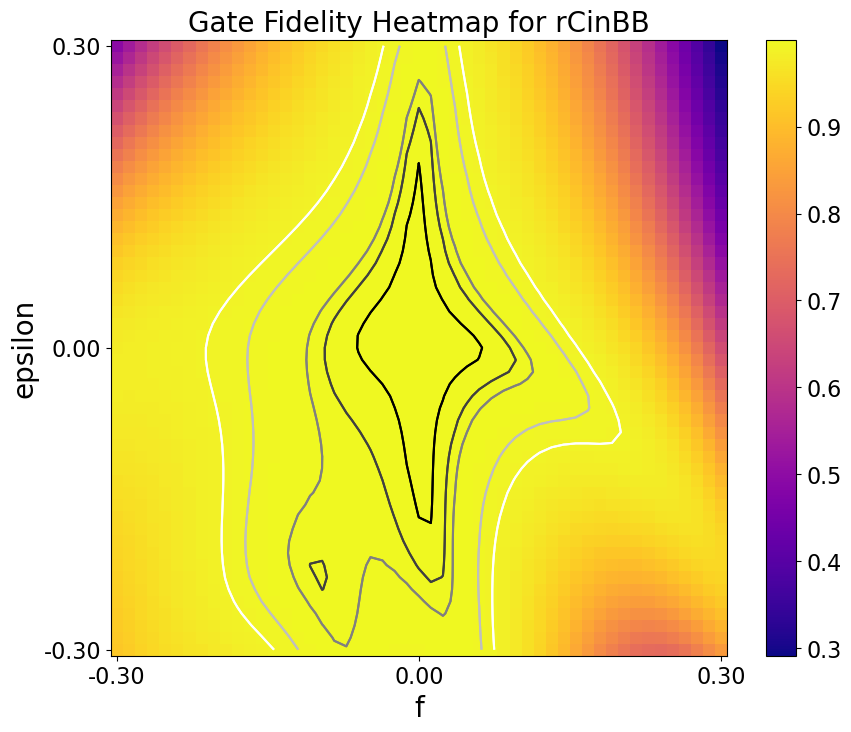

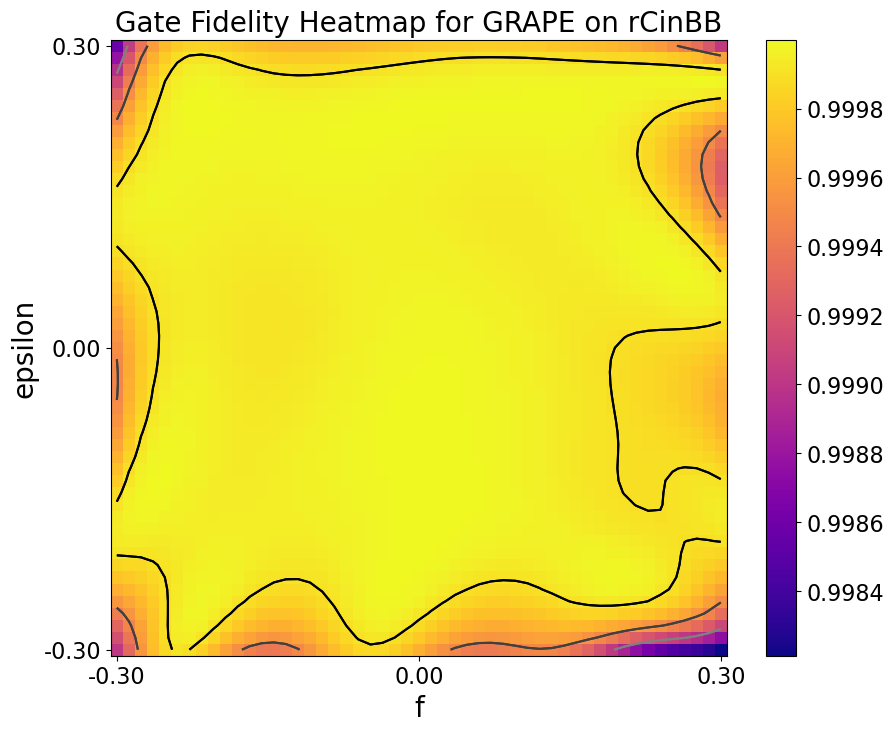

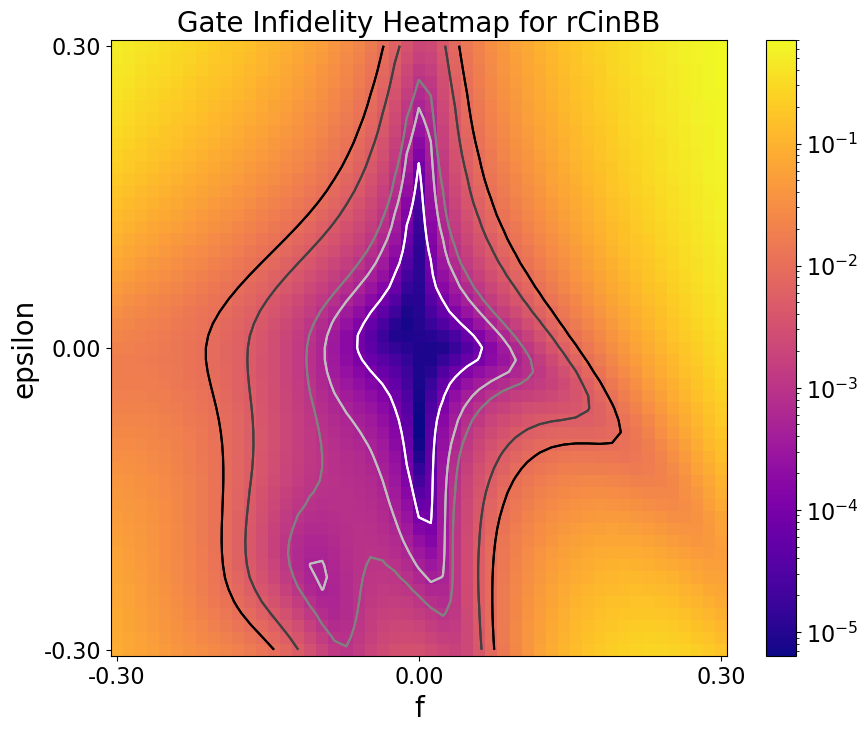

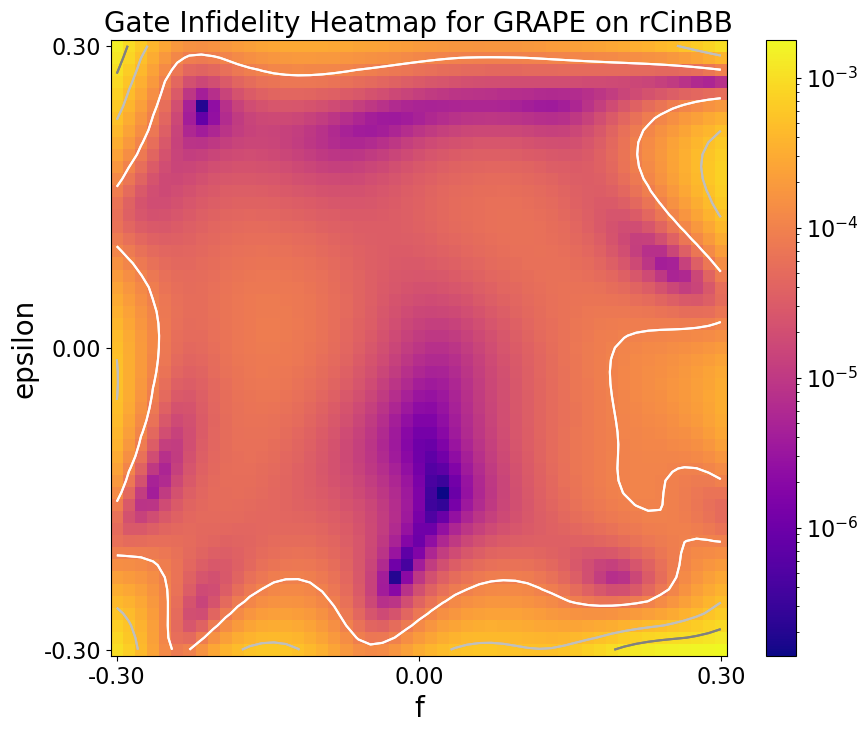

Checking the cumulative infidelity on the fine grid:
rCinBB: 108.69231623723104
GRAPE on rCinBB: 0.1754097719427979


In [8]:
plots.fidelity_heatmap_initial(0.3, 51, 0.3, 51)
plots.fidelity_heatmap_final(0.3, 51, 0.3, 51)
plots.infidelity_heatmap_initial(0.3, 51, 0.3, 51)
plots.infidelity_heatmap_final(0.3, 51, 0.3, 51)

def apply_gaussian_weights(matrix, sigma_epsilon, sigma_f, normalize=True):
    M, N = matrix.shape
    y_coords, x_coords = np.meshgrid(np.arange(M), np.arange(N), indexing="ij")
    center_x = (N - 1) / 2.0
    center_y = (M - 1) / 2.0
    
    gauss_mask = np.exp(-(((x_coords - center_x) ** 2) / (2.0 * sigma_epsilon ** 2) + ((y_coords - center_y) ** 2) / (2.0 * sigma_f ** 2)))

    if normalize: # Normalize mask so that its sum is N*M
        gauss_mask /= gauss_mask.sum()
        gauss_mask *= (M * N)
        
    return matrix * gauss_mask

print('Checking the cumulative infidelity on the fine grid:')
print(f'rCinBB: {np.sum(apply_gaussian_weights(1-plots.fidelity_initial, 51/3, 51/3))}')
print(f'GRAPE on rCinBB: {np.sum(apply_gaussian_weights(1-plots.fidelity_final, 51/3, 51/3))}')

/var/folders/q0/7f04j2qd3gl8slmzfbwlpdhr0000gn/T/ipykernel_67866/2754077280.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


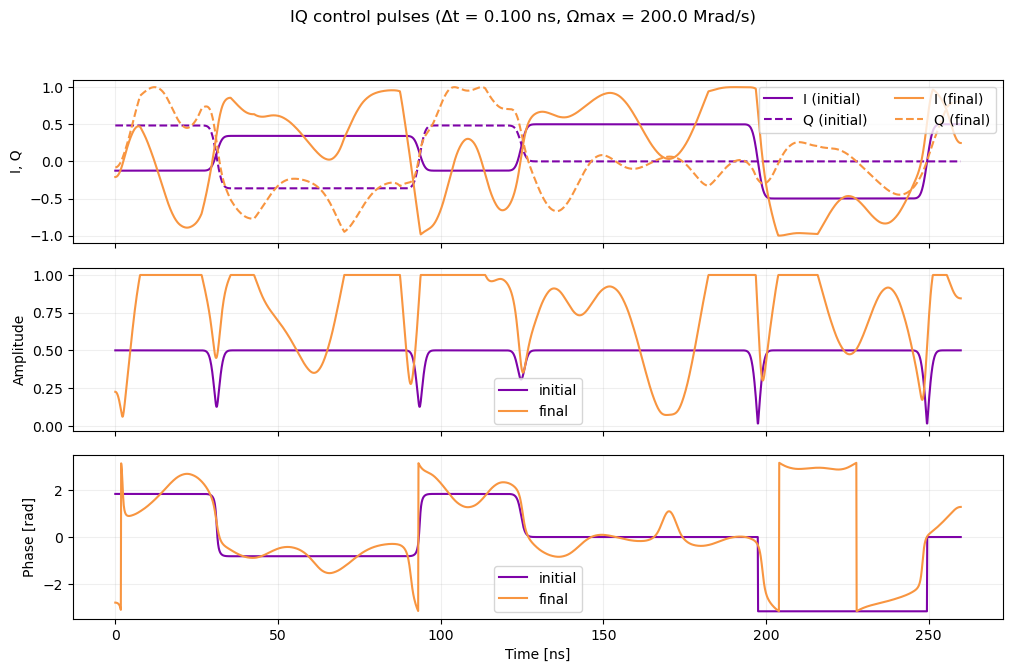

In [15]:
plots.show_pulse('ns')